## Problem Statement

#### Human Action Recognition (HAR) aims to understand human behavior and assign a label to each action. It has a wide range of applications, and therefore has been attracting increasing attention in the field of computer vision. Human actions can be represented using various data modalities, such as RGB, skeleton, depth, infrared, point cloud, event stream, audio, acceleration, radar, and WiFi signal, which encode different sources of useful yet distinct information and have various advantages depending on the application scenarios.
#### Consequently, lots of existing works have attempted to investigate different types of approaches for HAR using various modalities.
#### The Task is to build an Image Classification Model using CNN that classifies to which class of activity a human is performing.

## Importing Libraries and Configurations

In [112]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf### models
import numpy as np### math computations
import pandas as pd
import matplotlib.pyplot as plt### plotting bar chart
import matplotlib.image as img
%matplotlib inline
import cv2## image processing
import seaborn as sns### visualizations
import datetime
import pathlib
import shutil
import io
import os
import time
import random
import glob
from PIL import Image
import matplotlib.cm as cm
import albumentations as A
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape, RandomZoom)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

In [2]:
label_dict = {
    'calling': 0,
    'clapping': 1,
    'cycling': 2,
    'dancing': 3,
    'drinking': 4,
    'eating': 5,
    'fighting': 6,
    'hugging': 7,
    'laughing': 8,
    'listening_to_music': 9,
    'running': 10,
    'sitting': 11,
    'sleeping': 12,
    'texting': 13,
    'using_laptop': 14
}

In [3]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 15,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES":['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting',
    'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping',
    'texting', 'using_laptop'],
}

## Downloading the Data

In [61]:
train_data = pd.read_csv("D:\\Projects\\Human Action Recognition\\data\\Training_set.csv")
test_data = pd.read_csv("D:\\Projects\\Human Action Recognition\\data\\Testing_set.csv")

In [5]:
train_folder = "D:\\Projects\\Human Action Recognition\\data\\train"
test_folder = "D:\\Projects\\Human Action Recognition\\data\\test"

In [6]:
train_data

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop
...,...,...
12595,Image_12596.jpg,sitting
12596,Image_12597.jpg,clapping
12597,Image_12598.jpg,sitting
12598,Image_12599.jpg,dancing


In [7]:
train_data.label.value_counts()

label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64

In [8]:
labels = list(label_dict.keys())
print(labels)

['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']


In [65]:
# Loop through the DataFrame and rename the images
# For train
# for index, row in train_data.iterrows():
#     filename = row[0].strip()
#     label = row[1].strip()
#     new_filename = f"{labels[label_dict[label]]}_{filename}"
#     old_filepath = os.path.join(train_folder, filename)
#     new_filepath = os.path.join(train_folder, new_filename)
#     if os.path.exists(old_filepath):
#         os.rename(old_filepath, new_filepath)
#     else:
#         print(f"File {old_filepath} does not exist")

# print("Renaming complete")

Renaming complete


In [6]:
# Create a set of action labels from the label dictionary
actions = [
    'calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting',
    'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping',
    'texting', 'using_laptop'
]

In [ ]:
# Ensure each action has a corresponding folder
# for action in actions:
#     action_folder = os.path.join(train_folder, action)
#     os.makedirs(action_folder, exist_ok=True)

In [67]:
# Loop through the files in the train directory
# for filename in os.listdir(train_folder):
#     if os.path.isfile(os.path.join(train_folder, filename)):
#         # Extract the action label from the filename
#         action_label = filename.split('_')[0]
        
#         # Determine the destination folder
#         if action_label in actions:
#             destination_folder = os.path.join(train_folder, action_label)
#             # Move the file to the destination folder
#             shutil.move(os.path.join(train_folder, filename), os.path.join(destination_folder, filename))
#             print(f"Moved {filename} to {destination_folder}")

Moved calling_Image_10019.jpg to D:\Projects\Human Action Recognition\data\train\calling
Moved calling_Image_10022.jpg to D:\Projects\Human Action Recognition\data\train\calling
Moved calling_Image_10023.jpg to D:\Projects\Human Action Recognition\data\train\calling
Moved calling_Image_10027.jpg to D:\Projects\Human Action Recognition\data\train\calling
Moved calling_Image_1003.jpg to D:\Projects\Human Action Recognition\data\train\calling
Moved calling_Image_10034.jpg to D:\Projects\Human Action Recognition\data\train\calling
Moved calling_Image_10051.jpg to D:\Projects\Human Action Recognition\data\train\calling
Moved calling_Image_10059.jpg to D:\Projects\Human Action Recognition\data\train\calling
Moved calling_Image_10082.jpg to D:\Projects\Human Action Recognition\data\train\calling
Moved calling_Image_10084.jpg to D:\Projects\Human Action Recognition\data\train\calling
Moved calling_Image_10137.jpg to D:\Projects\Human Action Recognition\data\train\calling
Moved calling_Image_10

In [8]:
train_dataset, val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    labels='inferred',
    label_mode="categorical",
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=0.175,
    subset="both",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 12600 files belonging to 15 classes.
Using 10395 files for training.
Using 2205 files for validation.


In [52]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder,
    labels=None,
    label_mode=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 5410 files.


In [9]:
for i in train_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[1.12000000e+02, 1.11000000e+02, 1.09000000e+02],
         [1.12234375e+02, 1.11234375e+02, 1.09234375e+02],
         [1.14585938e+02, 1.13585938e+02, 1.11585938e+02],
         ...,
         [6.90000000e+01, 4.60000000e+01, 2.80000000e+01],
         [6.81171875e+01, 4.51171875e+01, 2.71171875e+01],
         [6.80000000e+01, 4.50000000e+01, 2.70000000e+01]],

        [[1.12000000e+02, 1.11000000e+02, 1.09000000e+02],
         [1.12234375e+02, 1.11234375e+02, 1.09234375e+02],
         [1.14585938e+02, 1.13585938e+02, 1.11585938e+02],
         ...,
         [6.90000000e+01, 4.60000000e+01, 2.80000000e+01],
         [6.81171875e+01, 4.51171875e+01, 2.71171875e+01],
         [6.80000000e+01, 4.50000000e+01, 2.70000000e+01]],

        [[1.12000000e+02, 1.11000000e+02, 1.09000000e+02],
         [1.12234375e+02, 1.11234375e+02, 1.09234375e+02],
         [1.14585938e+02, 1.13585938e+02, 1.11585938e+02],
         ...,
         

### Visualization

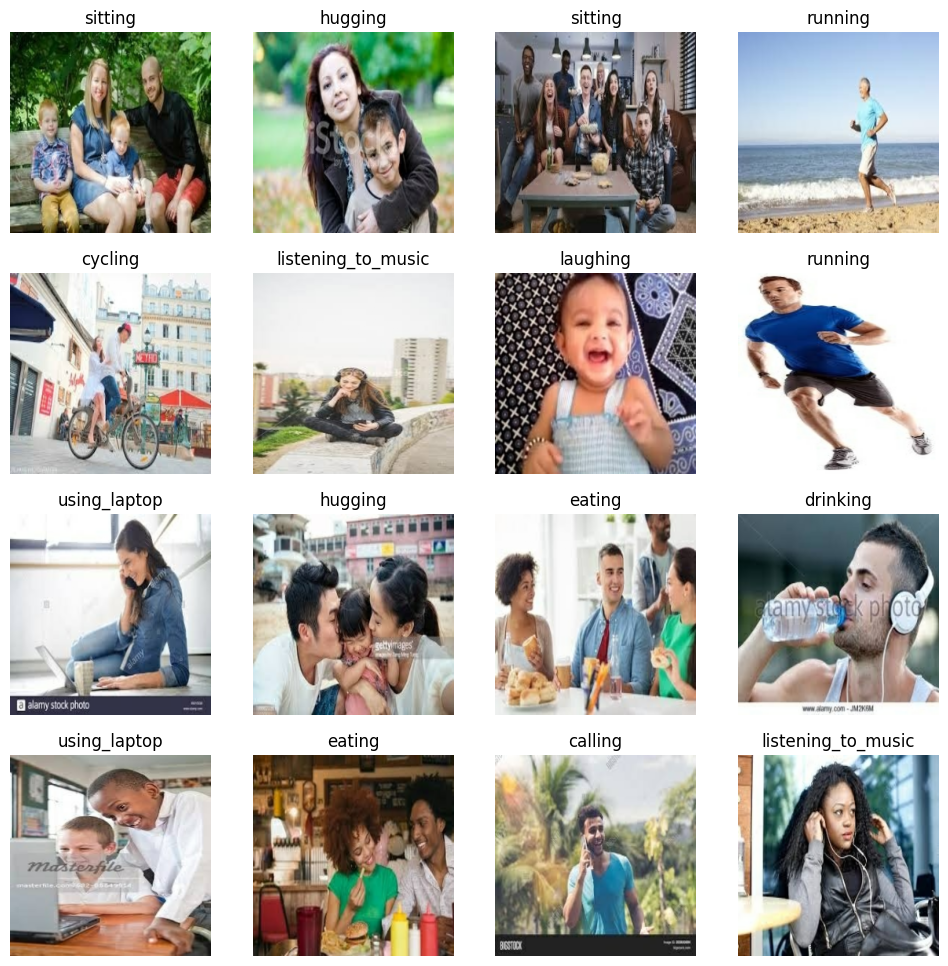

In [10]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
        plt.axis('off')

## Data Augmentation

In [12]:
augmentation_layer = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.04),
    RandomZoom(0.2),
    RandomContrast(0.1),
])

In [13]:
def augment_layer(image, label):
    return augmentation_layer(image, training = True), label

### Dataset Preparation

In [14]:
training_dataset = (train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE))
validation_dataset = (val_dataset.prefetch(tf.data.AUTOTUNE))

In [14]:
resize_rescale_layers = tf.keras.Sequential([
  Resizing(224, 224),
  Rescaling(1./255),
])

## Albumentation

In [39]:
# transforms = A.Compose(
#     [A.OneOf([A.HorizontalFlip(),
#                 A.VerticalFlip(),], p = 0.3),

#       A.RandomRotate90(),
#       A.RandomBrightnessContrast(brightness_limit=0.2,
#                                 contrast_limit=0.2,
#                                 always_apply=False, p=0.5),
#       A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5),
# ])

In [40]:
# def aug_albument(image):
#   data = {"image":image}
#   image = transforms(**data)
#   image = image["image"]
#   image = tf.cast(image/255., tf.float32)
#   return image

In [41]:
# def process_data(image, label):
#     aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
#     return aug_img, label

In [42]:
# train_dataset = (
#     train_dataset
#     .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
#     .map(process_data)
#     .batch(CONFIGURATION["BATCH_SIZE"])
#     .prefetch(tf.data.AUTOTUNE)
# )

## Modeling

In [122]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),
    
    resize_rescale_layers,
    
    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),
    
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │    47,776,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,915,647 (182.78 MB)

 Trainable params: 47,913,299 (182.77 MB)

 Non-trainable params: 2,348 (9.17 KB)

## Transfer Learning 

In [11]:
backbone = tf.keras.applications.EfficientNetV2S(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    include_preprocessing=True
    )

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


In [15]:
backbone.trainable = False

### Finetuning

In [54]:
### First set the backbone to False and after training the finetuned model set the backbone to True. Also recompile the model, reduce epochs by half, and divide the learning rate by 100 before underogoing training again
backbone.trainable = True

In [16]:
input = Input(shape = (CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"], 3))
x = backbone(input, training = False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu",)(x)
x = BatchNormalization()(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu",)(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

finetuned_model = Model(input, output)

In [55]:
finetuned_model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-s            │ (None, 8, 8, 1280)    │ 20,331,360 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1024)          │  1,311,744 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization         │ (None, 1024)          │      4,096 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 128)           │    131,200 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 15)            │      1,935 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 24,674,191 (94.12 MB)

 Trainable params: 21,624,415 (82.49 MB)

 Non-trainable params: 155,920 (609.06 KB)

 Optimizer params: 2,893,856 (11.04 MB)

## Tensorboard

In [18]:
metric_dir = './logs'
train_writer = tf.summary.create_file_writer(metric_dir + '/train')
val_writer = tf.summary.create_file_writer(metric_dir + '/val')

In [19]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime('%d%m%Y - %H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Training

In [20]:
checkpoint_callback = ModelCheckpoint('best_weights.keras', monitor='val_accuracy',mode = 'max', verbose = 1, save_best_only=True)

In [21]:
es_callback = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = False, verbose = 1, mode = 'auto', baseline = None, min_delta=0)

In [22]:
plateau_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

In [23]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name='accuracy')]

In [56]:
finetuned_model.compile(optimizer=Adam(learning_rate = CONFIGURATION['LEARNING_RATE']/100), loss = loss_function, metrics = metrics)

In [57]:
history = finetuned_model.fit(training_dataset, validation_data = validation_dataset, epochs = 10, verbose = 1, callbacks = [tensorboard_callback, checkpoint_callback])

Epoch 1/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5567 - loss: 2.1601
Epoch 1: val_accuracy did not improve from 0.76190
325/325 ━━━━━━━━━━━━━━━━━━━━ 2605s 8s/step - accuracy: 0.5566 - loss: 2.1594 - val_accuracy: 0.5882 - val_loss: 1.4892
Epoch 2/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5623 - loss: 1.4874
Epoch 2: val_accuracy did not improve from 0.76190
325/325 ━━━━━━━━━━━━━━━━━━━━ 2398s 7s/step - accuracy: 0.5624 - loss: 1.4872 - val_accuracy: 0.6562 - val_loss: 1.2502
Epoch 3/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6232 - loss: 1.2263
Epoch 3: val_accuracy did not improve from 0.76190
325/325 ━━━━━━━━━━━━━━━━━━━━ 2400s 7s/step - accuracy: 0.6232 - loss: 1.2261 - val_accuracy: 0.6844 - val_loss: 1.1298
Epoch 4/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6736 - loss: 1.0232
Epoch 4: val_accuracy did not improve from 0.76190
325/325 ━━━━━━━━━━━━━━━━━━━━ 2400s 7s/step - accuracy: 0.6737 - loss: 1.0231 - val_accuracy: 0.7061

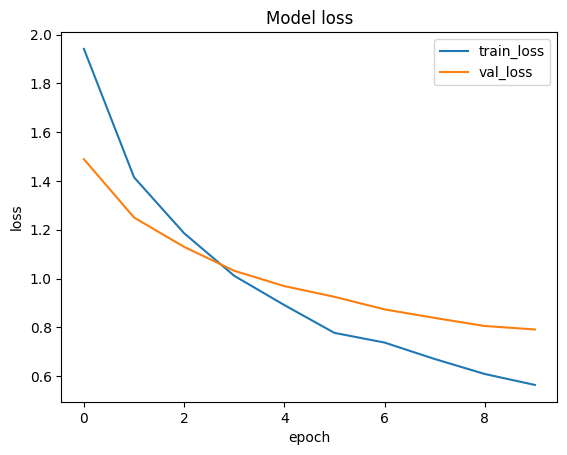

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

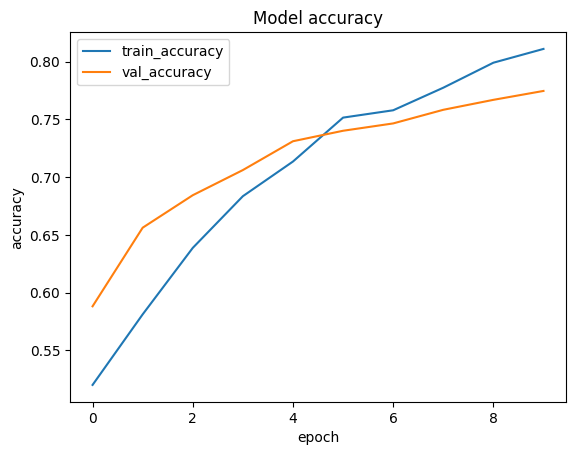

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

## Tensorboard Visualizations

In [127]:
%load_ext tensorboard
%tensorboard --logdir logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 15176), started 13:46:24 ago. (Use '!kill 15176' to kill it.)

## Prediction

In [ ]:
finetuned_model.load_weights('best_weights')

In [123]:
predictions = finetuned_model.predict(test_dataset)

170/170 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step


In [124]:
predicted_classes = np.argmax(predictions, axis=1)

In [135]:
def read_img(fn):
    img = Image.open(fn)
    return np.asarray(img.resize((256,256)))

In [133]:
def test_predict(test_image):
    result = finetuned_model.predict(np.asarray([read_img(test_image)]))

    itemindex = np.where(result==np.max(result))
    prediction = itemindex[1][0]
    print("probability: "+str(np.max(result)*100) + "%\nPredicted class : ", prediction)

    image = img.imread(test_image)
    plt.imshow(image)
    plt.title(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
probability: 99.9997615814209%
Predicted class :  2


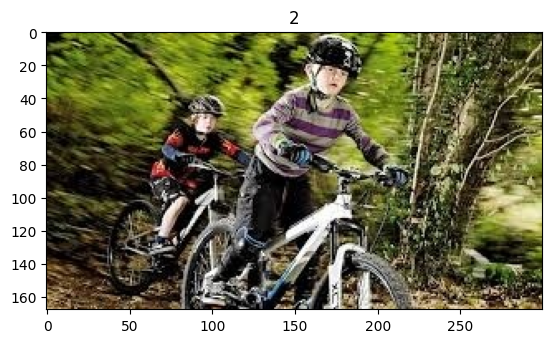

In [140]:
test_predict("D:\\Projects\\Human Action Recognition\\data\\test\\Image_560.jpg")

## Testing

In [109]:
def class_prediction(file):
    test_image = cv2.imread(file)
    resized_image = cv2.resize(test_image, (256, 256))
    im = tf.constant(resized_image, dtype = tf.float32)
    im = tf.expand_dims(im, axis = 0)
    predicted_class = tf.argmax(finetuned_model(im), axis=-1).numpy()[0]

    # Print the predicted class name
    print(CONFIGURATION['CLASS_NAMES'][predicted_class])

In [119]:
class_prediction("D:\\Projects\\Human Action Recognition\\data\\test\\Image_232.jpg")

clapping
